# Quantum teleportation using feed-forward

The goal of this notebook is to use perceval's feed-forward ability to demonstrate the Quantum teleportation algorithm \[1\] on a photonic simulated circuit using dual rail encoding.

## Definition of the problem

The idea of the algorithm is the following:

Say that Alice has a generic qubit of the form

$$|\psi\rangle = \alpha |0\rangle + \beta |1> $$

that she wants to send to a distant receiver called Bob. Since Bob is distant, we want to avoid transporting physical systems from Alice to Bob.

Before the start of the algorithm, Alice and Bob need to share a maximally entangled Bell state. For this example, we will use the form

$$|\Psi\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$

The first qubit is accessible to Alice and the second to Bob.

The total state is then

$$|\psi\rangle \otimes \Psi\rangle = (\alpha |0\rangle + \beta |1\rangle) \otimes \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$

The algorithm is the following:
Alice performs a CNOT operation using the first qubit as control and the second as target, then applies a H gate to the first qubit.

![quantum_teleportation_circuit.jpg](../_static/img/quantum_teleportation_circuit.jpg)

At the end, the total state can be written as

\begin{align}
    |final\rangle &= \frac{1}{2}|00\rangle \otimes (\alpha |0\rangle + \beta |1>) \\
                  &+ \frac{1}{2}|01\rangle \otimes (\beta |0\rangle + \alpha |1>) \\
                  &+ \frac{1}{2}|10\rangle \otimes (\alpha |0\rangle - \beta |1>) \\
                  &+ \frac{1}{2}|11\rangle \otimes (- \beta |0\rangle + \alpha |1>)
\end{align}

Then Alice needs to measure her two qubits and send the results to Bob using a classical channel.

If the second qubit is measured as 1, Bob must apply a NOT gate to his qubit.

If the first qubit is measured to be 1, Bob must then apply a Z gate to his qubit.

After these operations, Bob's qubit is guaranteed to be the original qubit of Alice $|\psi\rangle$.

## Translation to Perceval

In [1]:
import numpy as np

import perceval as pcvl
from perceval import catalog

### Starting state

First, we need to create the input state $|\psi\rangle \otimes |\Psi\rangle$ for this algorithm. We choose $\alpha$ and $\beta$ arbitrarily.

In [2]:
# Creation of the qubit to transmit

alpha = .2  # Arbitrarily chosen
beta = .1 + .3j
# alpha |0> + beta |1> in dual rail encoding
to_transmit = alpha * pcvl.BasicState([1, 0]) + beta * pcvl.BasicState([0, 1])
to_transmit.normalize()

print(to_transmit)

0.535*|1,0>+(0.267+0.802I)*|0,1>


In [3]:
# Creation of the quantum channel
sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")
print(bell_state)

0.707*|1,0,1,0>+0.707*|0,1,0,1>


In [4]:
input_state = to_transmit * bell_state

### Tomography

Since we could end up with both $\alpha |0\rangle + \beta |1\rangle$ and $\alpha |0\rangle - \beta |1\rangle$ states, we want to be able to distinguish them to prove that the algorithm effectively works. For this, as their resulting probability from a direct measurement would be the same, we use state tomography.

Since a qubit is defined up to a global rotation, we consider that $\alpha$ is a real non-negative number. In our simple case, we don't need to use all Pauli gates.

In [5]:
# Needed if the number of modes is bigger than 2
def squash_results(res, first_mode: int):
    """Sum the output probabilities to keep only the qubit of interest indexed by its first mode"""
    bsd = pcvl.BSDistribution()
    for state, prob in res.items():
        bsd[state[first_mode:first_mode+2]] += prob

    return bsd

def tomography(processor: pcvl.Processor, first_mode: int = 0) -> pcvl.StateVector:
    # First using identity, we get alpha ** 2 and |beta| ** 2
    res = processor.probs()["results"]
    res = squash_results(res, first_mode)

    alpha = res[pcvl.BasicState([1, 0])] ** .5
    if alpha == 0:
        return pcvl.StateVector(pcvl.BasicState([0, 1]))

    processor = processor.copy()
    # We do the same, but we add a H gate at the end for the qubit we are interested in
    processor.add(first_mode, pcvl.BS.H())
    res = processor.probs()["results"]
    res = squash_results(res, first_mode)

    p0 = res[pcvl.BasicState([1, 0])]  # 1/2 |alpha + beta| ** 2
    p1 = res[pcvl.BasicState([0, 1])]  # 1/2 |alpha - beta| ** 2

    # By writing beta = x + i y, we get
    x = (p0 - p1) / (2 * alpha)

    processor = processor.copy()
    # We do the same, but we multiply by i the amplitudes of qubit |1> before applying the H gate
    processor.add(first_mode + 1, pcvl.PS(np.pi / 2))
    processor.add(first_mode, pcvl.BS.H())
    res = processor.probs()["results"]
    res = squash_results(res, first_mode)

    p0 = res[pcvl.BasicState([1, 0])]  # 1/2 |alpha + i beta| ** 2
    p1 = res[pcvl.BasicState([0, 1])]  # 1/2 |alpha - i beta| ** 2

    y = (p0 - p1) / (2 * alpha)
    beta = x + 1j * y

    return alpha * pcvl.BasicState([1, 0]) + beta * pcvl.BasicState([0, 1])

We can now test this algorithm on our original qubit using an identity circuit.

In [6]:
p = pcvl.Processor("SLOS", 2)

p.min_detected_photons_filter(1)
p.with_input(to_transmit)

tomography(p)

0.535*|1,0>+(0.267+0.802I)*|0,1>

We get the same state so the tomography process works.

### Circuit

Now we need to define the circuit on which the operations will take place. Since we need to use gates and feed-forward components, we need to use a `Processor` object.

First, we define the photonic circuit that applies on the qubits.

In [7]:
p = pcvl.Processor("SLOS", 6)
p.add(0, catalog["heralded cnot"].build_processor())
p.add(0, pcvl.BS.H());

Now we need to add the feed-forwarded components. For this purpose, Perceval uses two configurators that link measurements to circuits or processors.

Both of them need to be defined by the number of modes they measure, the distance between the measured modes and the circuit they configure (this is an integer called `offset`), and a default configuration that is used whenever a measure does not befall into one of the defined cases.

The measured modes need to be classical modes. Thus, we need to add detectors before adding the configurators.

For the NOT gate, this gate corresponds to a permutation for a dual rail encoding if we measure $|1\rangle$, or an empty circuit if we measure $|0\rangle$. Thus, we are going to use a `FFCircuitProvider` as it links a measured state to a circuit or a processor.

In [8]:
# 2 measured modes
# offset = 0 means that there is 0 empty modes between the measured modes and the circuit
# the default circuit is an empty circuit
ff_not = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_not.add_configuration([0, 1], pcvl.PERM([1, 0]))

# Add perfect detectors to the modes that will be measured
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())
p.add(2, ff_not);

The Z gate corresponds to a $\pi$ shift on the second mode. Thus, we are going to use a `FFConfigurator` that uses a parametrized circuit and links the measured states to a mapping of values for these parameters.

In [9]:
phi = pcvl.P("phi")
# Like Circuits and Processors, we can chain the `add` methods
ff_z = pcvl.FFConfigurator(2, 3, pcvl.PS(phi), {"phi": 0}).add_configuration([0, 1], {"phi": np.pi})

p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
p.add(0, ff_z);

We can check that we defined correctly our processor. Note that using the `recursive=True` flag, we can expose the inner circuit of the `FFConfigurator`.

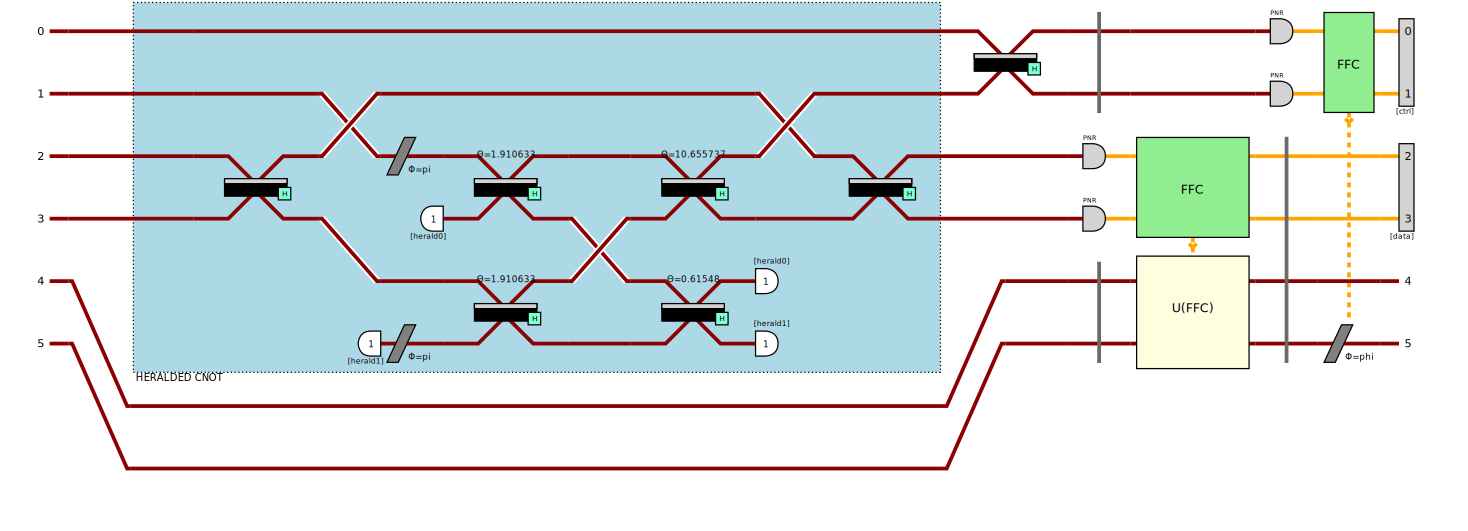

In [10]:
pcvl.pdisplay(p, recursive=True)

### Simulation

Now that we have both the input state and the processor, we can run the algorithm and check that it works.

In [11]:
p.min_detected_photons_filter(3)

# Since we use a "custom" (understand not a BasicState) input state,
# we have to add the heralds from the heralded cnot manually
input_state *= pcvl.BasicState([1, 1])

p.with_input(input_state)

res = p.probs()
print(res)

{'results': BSDistribution(<class 'float'>, {|0,1,0,1,1,0>: 0.07142857142857213, |0,1,0,1,0,1>: 0.1785714285714302, |0,1,1,0,0,1>: 0.17857142857142813, |0,1,1,0,1,0>: 0.07142857142857124, |1,0,1,0,1,0>: 0.07142857142856994, |1,0,1,0,0,1>: 0.17857142857142483, |1,0,0,1,1,0>: 0.07142857142857247, |1,0,0,1,0,1>: 0.17857142857143113}), 'global_perf': 0.07407407407408272}


Notice that when using feed-forward, the performance indicators are replaced by a single indicator "global_perf", which represents the probability that an output state checks all requirements. In our case, this corresponds to the CNOT gate performance: $2 / 27 \approx 0.074$.

For the results, we don't need to know what was measured by Alice, so we need to squash the resulting probabilities to keep only the two last modes.

In [12]:
print(squash_results(res["results"], 4))

{
  |1,0>: 0.28571428571428575
  |0,1>: 0.7142857142857143
}


We can now apply our tomography process to check that Bob's qubit is now the initial qubit that Alice wanted to transmit.

In [13]:
print(tomography(p, 4))

0.535*|1,0>+(0.267+0.802I)*|0,1>


We get the state that we wanted to transmit, meaning that the algorithm works well with perceval's feed-forward feature.

## References

> [1] C. H. Bennett, G. Brassard, C. Crépeau, R. Jozsa, A. Peres and W. K. Wootters, “Teleporting an unknown quantum state via dual classical and Einstein-Podolsky-Rosen channels”, [Phys. Rev. Lett.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895) **70**, 1895 (1993).